## Set up working environment for tensorflow

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input, utils
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg19 import VGG19
from tensorboard import program
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os

In [2]:
def config_gpu():
    #Configure Gpus
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

In [3]:
config_gpu()

1 Physical GPUs, 1 Logical GPUs


## Tensorboard monitoring

In [4]:
tb = program.TensorBoard()
tb.configure(argv=[None, '--logdir', "."])
url = tb.launch()
print("Tensorboard url: ", url)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

Tensorboard url:  http://localhost:6006/


## Reading in data 

In [5]:
# Create a tensorflow pipeline

list_ds = tf.data.Dataset.list_files('Data/*/*')

# The files in each class directory are examples, list 10 of them
for f in list_ds.take(5):
    filename = f.numpy().decode('ascii')
    print(filename)

Data\DME\DME-30521-54.jpeg
Data\DME\DME-1591159-10.jpeg
Data\DRUNSEN\DRUSEN-2437193-26.jpeg
Data\DME\DME-3064922-153.jpeg
Data\NORMAL\NORMAL-194489-17.jpeg


In [6]:
# print the length of entire dataset
DATA_LENGTH = tf.data.experimental.cardinality(list_ds).numpy() # len(list(list_ds)) is not efficient
print(f"Data length: {DATA_LENGTH}")

Data length: 10000


## Checkpoint 1: Define Training/Test data size and dimension. Explain the rationale for your selection.

In [7]:
TEST_SIZE = 0.25
IMG_SIZE = (64,64)
BATCH_SIZE = 32

print(f"Number of train samples: {(1 - TEST_SIZE) * DATA_LENGTH}")
print(f"Number of test samples: {TEST_SIZE * DATA_LENGTH}")
print(f"Resized Image dimension: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Input model shape: {(BATCH_SIZE, *IMG_SIZE, 1)}") # grayscale image only has 1 channel

Number of train samples: 7500.0
Number of test samples: 2500.0
Resized Image dimension: (64, 64)
Batch size: 32
Input model shape: (32, 64, 64, 1)


The dataset consists of 10,000 images which is a sizeable amount. Based on online searches, 75-25 train-test split is commonly used. I do not want to set a higher ratio for test set because it means longer training time and less test images for validation. Setting `TEST_SIZE = 0.25` is reasonable.

I set `img_size=(64,64)` as the images have different dimensions, and they all have to be reshaped to a fixed dimension before being fed into the model. The value is chosen to be smaller than the original image to reduce the intensive computation time (e.g. due to convolution) on my local machine, but big enough for a good resolution such that the overall accuracy is not compromised.

## Encoding labels as integers

In [8]:
def get_label_dict(path):
    # returns a dictionary with label as key, and idx as value
    label_dict = {}
    for idx, label in enumerate(os.listdir(path)):
        label_dict[label] = idx
    return label_dict

def label2idx(label):
    # converts string label to integer index
    return label_dict[label]

In [9]:
label_dict = get_label_dict('Data')

label_dict

{'CNV': 0, 'DME': 1, 'DRUNSEN': 2, 'NORMAL': 3}

## Preprocessing Images Functions 

In [10]:
def tensor_str2int(text):
    # converts tensor string eagerly and converts to integer index
    idx = label2idx(text.numpy().decode('ascii'))
    return tf.constant(idx, dtype='int32')

def process_path(file_path):
    # read in the raw features and the label
    img_bytes = tf.io.read_file(file_path)
    label_str = tf.strings.split(file_path, os.sep)[-2]
    
    # prepare img as input x
    img_decoded = tf.image.decode_jpeg(img_bytes) # decode using jpeg format
    img_scaled = tf.image.convert_image_dtype(img_decoded, tf.float32) # convert to float values in [0,1]
    img_resized = tf.image.resize(img_scaled, IMG_SIZE) # resize to a specific size
    
    # prepare label as input y
    label_int = tf.py_function(tensor_str2int, [label_str], tf.int32)
    
    return img_resized, label_int

def train_preprocess(image, label):
    # can be optionally used during training to perform data augmentation
    
    # horizontally flips the image with probability 1/2
    image = tf.image.random_flip_left_right(image)

    # apply random brightness and saturation
    image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    
    # make sure the image is still in [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

In [11]:
# prepare the dataset in the form of X,y
dataset = list_ds.map(process_path)

## Checkpoint 2: Print a sample of the data. Explain the selected range and the purpose of normalisation.

x is: [[[0.13308825]
  [0.23455884]
  [0.09632353]
  ...
  [0.18676472]
  [0.1397059 ]
  [0.14093138]]

 [[0.23333335]
  [0.08921569]
  [0.1394608 ]
  ...
  [0.10784315]
  [0.21568629]
  [0.11691177]]

 [[0.06446078]
  [0.08063726]
  [0.13112748]
  ...
  [0.17843138]
  [0.13186276]
  [0.1509804 ]]

 ...

 [[0.05759804]
  [0.01053922]
  [0.06838235]
  ...
  [0.07794118]
  [0.03553922]
  [0.03333334]]

 [[0.08897059]
  [0.06617647]
  [0.0892157 ]
  ...
  [0.01985294]
  [0.02867647]
  [0.05343138]]

 [[0.03921569]
  [0.00588235]
  [0.06691177]
  ...
  [1.        ]
  [1.        ]
  [1.        ]]]
y is: 1


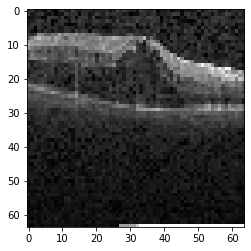

In [12]:
# print a sample of the data
for x,y in dataset.take(1):
    print("x is: {}".format(x))
    print("y is: {}".format(y))
    plt.imshow(x, cmap='gray')

Normalization changes the range of pixel intensity values from [0, 255] to [0, 1], which is preferred for neural networks so that the linear combination for weight calculation is more controlled.

## Build Base Model 

In [13]:
class MyModel(Model):
    def __init__(self, dim):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(32, 3, padding='same', activation='relu')
        self.pool = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')
        self.flatten = Flatten()
        self.d1 = Dense(256, activation='relu')
        self.d2 = Dense(128, activation='relu')
        self.d3 = Dense(4, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        return x
    
    def build_graph(self):
        x = Input(shape=(dim))
        return Model(inputs=[x], outputs=self.call(x))

In [14]:
dim = (*IMG_SIZE, 1) # img is grayscale, so only 1 channel
cnn_model = MyModel(dim)
cnn_model.build((BATCH_SIZE, *dim))

## Checkpoint 3: Display the graph. Print out of the model.

In [15]:
cnn_model.build_graph().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516   

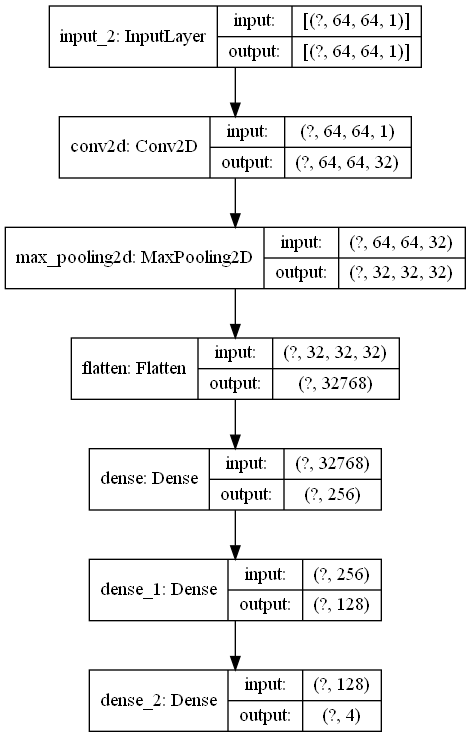

In [16]:
utils.plot_model(cnn_model.build_graph(), to_file='cnn_model.png', show_shapes=True)

## Checkpoint 4: Explain selection of loss function and optimiser Optimizer 

In [17]:
# Define Loss function and Optimiser

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

I use SparseCategoricalCrossentropy loss function because there are two or more label classes. Also, I will be encoding the labels as integers (as opposed to using CategoricalCrossEntropy using one-hot representation).

I use Adam becuase it combines the good properties of Adadelta and RMSprop and hence tend to do better for most of the problems. Choosing Adam sounds like a reasonable approach to begin with.

## Metrics to measure the loss and the accuracy of the model

In [18]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

## Define Training/Testing Function

In [19]:
def train_step(model, optimizer, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)

def test_step(model, images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)
    
    test_loss(t_loss)
    test_accuracy(labels, predictions)

## Split the dataset and train my own model 

In [20]:
# Split the dataset
dataset = dataset.shuffle(DATA_LENGTH)

train_ds = dataset.take(round(DATA_LENGTH * TEST_SIZE)).batch(BATCH_SIZE)
test_ds = dataset.skip(round(DATA_LENGTH * (1-TEST_SIZE))).batch(BATCH_SIZE)

In [21]:
def run_model(model, train_ds, test_ds, epochs):
    train_loss_hist = []
    train_acc_hist = []
    test_loss_hist = []
    test_acc_hist = []

    for epoch in range(epochs):
        for images, labels in train_ds:
            train_step(model, optimizer, images, labels)
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

        for test_images, test_labels in test_ds:
            test_step(model, test_images, test_labels)
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)

        # for plotting
        train_loss_hist.append(train_loss.result())
        train_acc_hist.append(train_accuracy.result())
        test_loss_hist.append(test_loss.result())
        test_acc_hist.append(test_accuracy.result())

        # print the results
        template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
        print(template.format(epoch+1,
                            train_loss.result(),
                            train_accuracy.result()*100,
                            test_loss.result(),
                            test_accuracy.result()*100))

        # Reset the metrics for the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()
        
    return train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist

In [22]:
EPOCHS = 20
train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist = run_model(cnn_model, train_ds, test_ds, epochs=EPOCHS)

Epoch 1, Loss: 1.315233588218689, Accuracy: 35.52000045776367, Test Loss: 1.2282979488372803, Test Accuracy: 42.7599983215332
Epoch 2, Loss: 1.1739070415496826, Accuracy: 46.23999786376953, Test Loss: 1.1078839302062988, Test Accuracy: 49.84000015258789
Epoch 3, Loss: 1.0736932754516602, Accuracy: 52.39999771118164, Test Loss: 1.0273503065109253, Test Accuracy: 57.08000183105469
Epoch 4, Loss: 0.9883877038955688, Accuracy: 57.480003356933594, Test Loss: 0.8768959641456604, Test Accuracy: 62.840003967285156
Epoch 5, Loss: 0.8940498232841492, Accuracy: 62.31999969482422, Test Loss: 0.9047102928161621, Test Accuracy: 61.47999572753906
Epoch 6, Loss: 0.8156445622444153, Accuracy: 66.5199966430664, Test Loss: 0.7397220134735107, Test Accuracy: 70.44000244140625
Epoch 7, Loss: 0.7576097249984741, Accuracy: 68.76000213623047, Test Loss: 0.7315244078636169, Test Accuracy: 70.0
Epoch 8, Loss: 0.6728907823562622, Accuracy: 74.04000091552734, Test Loss: 0.60838782787323, Test Accuracy: 76.2399978

## Checkpoint 5: Display training loss-epoch graph

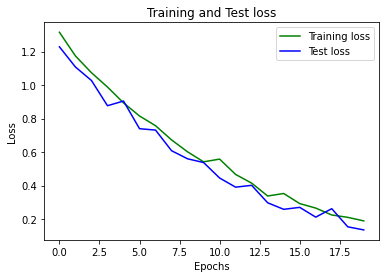

In [23]:
plt.plot(range(EPOCHS), train_loss_hist, 'g', label='Training loss')
plt.plot(range(EPOCHS), test_loss_hist, 'b', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

There are no anomalies. The training and test loss values are in sync across epochs and decreasing steadily, slowly saturating near 0.

## Checkpoint 6: Display Accuracy-epoch graph

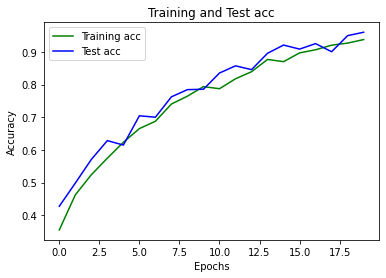

In [24]:
plt.plot(range(EPOCHS), train_acc_hist, 'g', label='Training acc')
plt.plot(range(EPOCHS), test_acc_hist, 'b', label='Test acc')
plt.title('Training and Test acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

There are no anomalies. The training and test accuracy values are in sync across epochs and increasing in a characteristic log shape that saturates near 1.

## Checkpoint 7: Define and explain the choice of transfer base model for transfer learning

VGG19 is a variant of VGG model which in short consists of 19 layers (16 convolution layers, 3 Fully connected layer, 5 MaxPool layers and 1 SoftMax layer). There are other variants of VGG like VGG11, VGG16 and others. VGG19 has 19.6 billion FLOPs.

Architecture:
- A fixed size of (224 * 224) RGB image was given as input to this network which means that the matrix was of shape (224,224,3).
- The only preprocessing that was done is that they subtracted the mean RGB value from each pixel, computed over the whole training set.
- Used kernels of (3 * 3) size with a stride size of 1 pixel, this enabled them to cover the whole notion of the image.
- Spatial padding was used to preserve the spatial resolution of the image.
- Max pooling was performed over a 2 * 2 pixel windows with stride 2.
- This was followed by Rectified linear unit(ReLu) to introduce non-linearity to make the model classify better and to improve computational time as the previous models used tanh or sigmoid functions this proved much better than those.
- Implemented three fully connected layers from which first two were of size 4096 and after that a layer with 1000 channels for 1000-way ILSVRC classification and the final layer is a softmax function.

I chose VGG19 model because it has a commendable Top-5 accuracy of 0.900 in the ImageNet competition. The choice was intentional as it has significantly more layers and trainable parameters, so I wanted to see how such a network would fare against my simple CNN network in an image classification task of an uncommon custom dataset.

In [25]:
class VGGModel(Model):
    def __init__(self, dim):
        super(VGGModel, self).__init__()
        self.repeat = tf.repeat
        self.base = VGG19(include_top=False, weights='imagenet')
        self.gap = GlobalAveragePooling2D()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(256, activation='relu')
        self.d3 = Dense(4, activation='softmax')
    
    def call(self, x):
        x = self.repeat(x, repeats=[3], axis=-1) # base model requires 3 channels, but our grayscale img only has 1 channel
        x = self.base(x)
        x = self.gap(x)
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        return x
    
    def build_graph(self):
        x = Input(shape=(dim))
        return Model(inputs=[x], outputs=self.call(x))

In [26]:
vgg_model = VGGModel(dim)
vgg_model.build((BATCH_SIZE, *dim))

## Checkpoint 8: Display graph printout of the base model with the OCT image classication extension

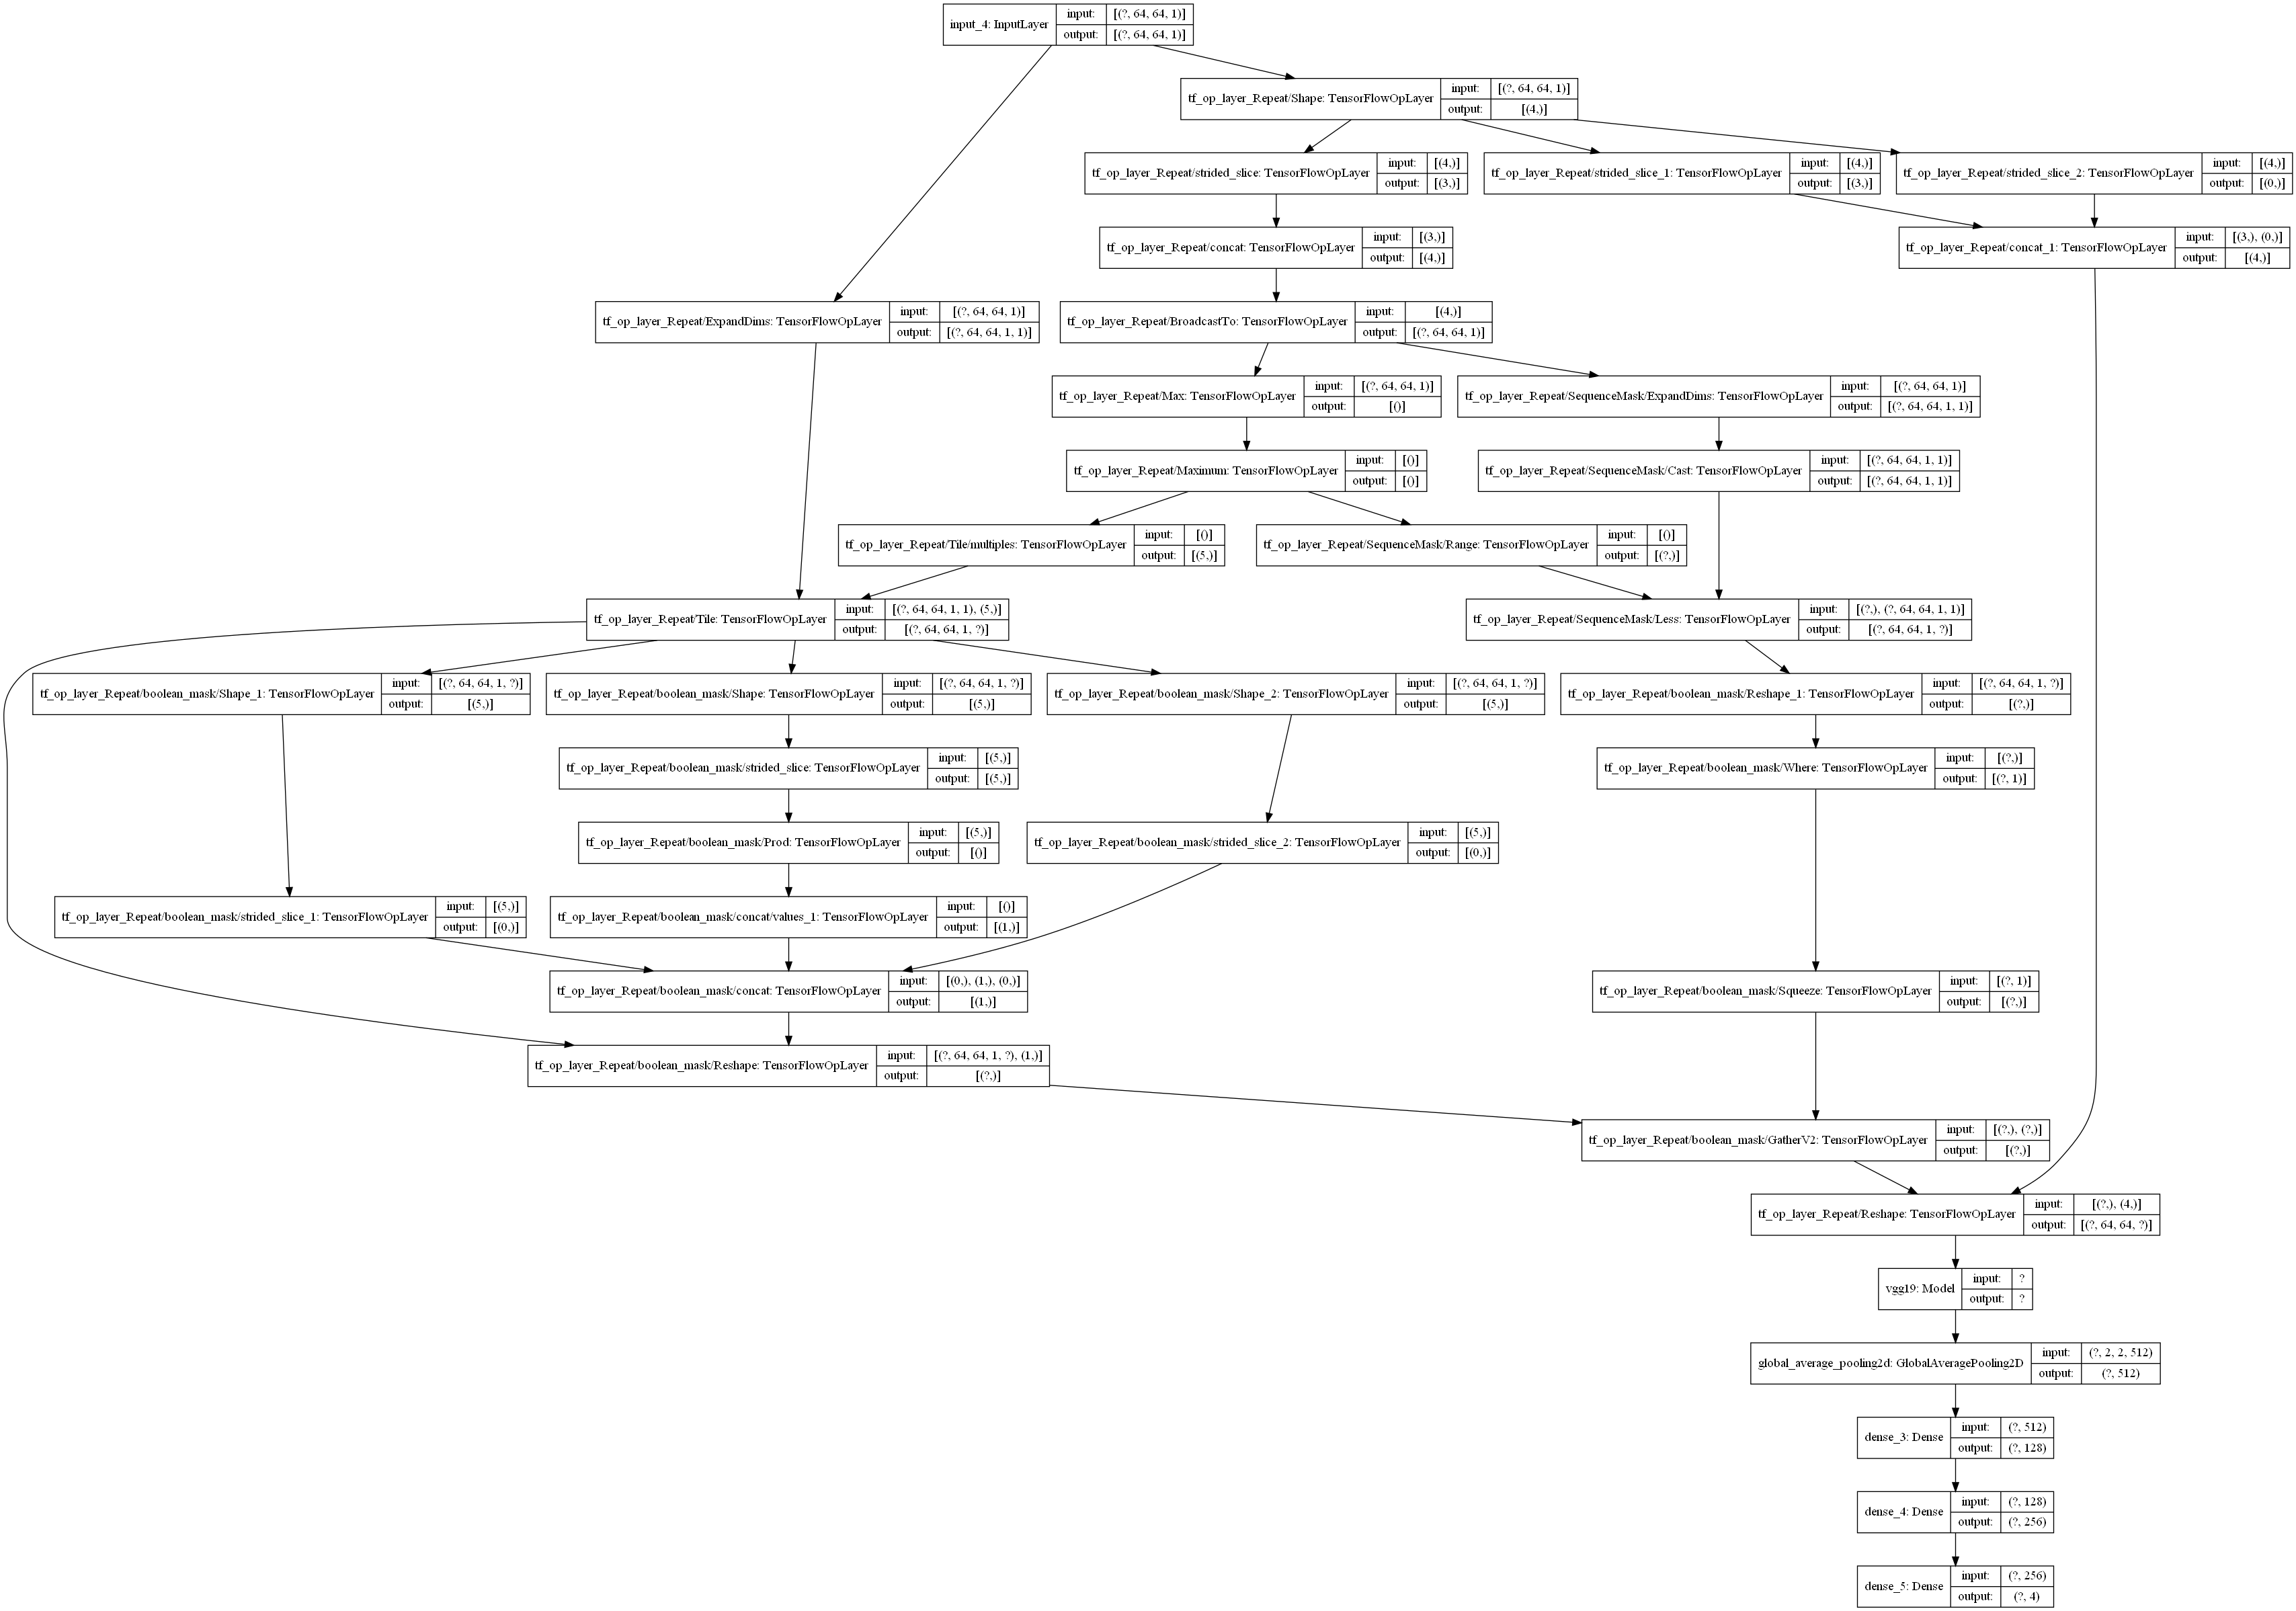

In [27]:
utils.plot_model(vgg_model.build_graph(), to_file='vgg_model.png', show_shapes=True)

## Train the transfer learning model 

In [28]:
EPOCHS = 20
train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist = run_model(vgg_model, train_ds, test_ds, epochs=EPOCHS)

Epoch 1, Loss: 11.37486743927002, Accuracy: 28.760000228881836, Test Loss: 11.584881782531738, Test Accuracy: 28.439998626708984
Epoch 2, Loss: 11.565753936767578, Accuracy: 28.0, Test Loss: 11.253334999084473, Test Accuracy: 30.239999771118164
Epoch 3, Loss: 11.215082168579102, Accuracy: 30.479999542236328, Test Loss: 11.266091346740723, Test Accuracy: 30.440000534057617
Epoch 4, Loss: 11.40635871887207, Accuracy: 29.0, Test Loss: 11.01742935180664, Test Accuracy: 31.15999984741211
Epoch 5, Loss: 11.47011661529541, Accuracy: 28.880001068115234, Test Loss: 11.380853652954102, Test Accuracy: 29.440000534057617
Epoch 6, Loss: 11.317098617553711, Accuracy: 30.1200008392334, Test Loss: 11.317093849182129, Test Accuracy: 29.840002059936523
Epoch 7, Loss: 11.011054992675781, Accuracy: 31.200000762939453, Test Loss: 10.998303413391113, Test Accuracy: 31.279998779296875
Epoch 8, Loss: 11.291593551635742, Accuracy: 30.280000686645508, Test Loss: 11.438240051269531, Test Accuracy: 29.07999992370

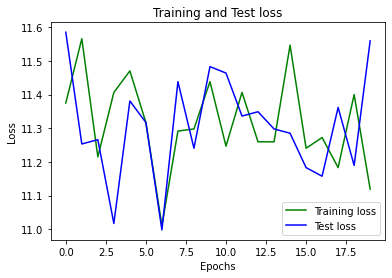

In [29]:
# loss-epoch graph
plt.plot(range(EPOCHS), train_loss_hist, 'g', label='Training loss')
plt.plot(range(EPOCHS), test_loss_hist, 'b', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

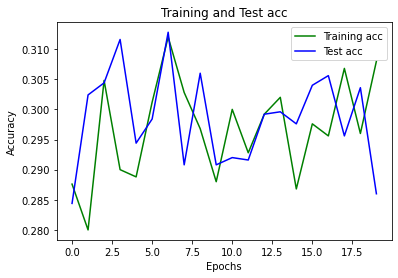

In [30]:
# accuracy-epoch graph
plt.plot(range(EPOCHS), train_acc_hist, 'g', label='Training acc')
plt.plot(range(EPOCHS), test_acc_hist, 'b', label='Test acc')
plt.title('Training and Test acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Checkpoint 9: Compare our own model and the transfer learning model
The training data currently being used is simple and as such transfer learning isn't as advantageous, however some observations can be made when comparing the first model with the second, discuss these observation.

Our model is very simple architecture with only 1 convolution layer and 1 max pooling layer. However, the VGG19 model is 19 layers deep with many convolution and pooling layers.

<u>Observation 1</u>

Based on the performance scores, our simple model performs significantly better with lower loss and higher accuracy. This could be because when there are too many layers, the extracted features in the deeper layers are more precise and less generalizable. Hence, the model is likely to overfit on the train dataset. 

A possible improvement is to freeze the more shallow layers since the features learnt here are more generic, and unfreeze the deeper layers to finetune the model parameters to better learn the specific features of our custom dataset.

<u>Observation 2</u>

Train and test loss and accuracy values of our model are improving across epochs, while those of the VGG model remain unchanged. This could be because when loading the pretrained model, the loss is already stuck at a local minimum, and that the weight update is not sufficient to reduce the loss to another local minimum. As a result, the train and test loss and accuracy values of the VGG model are not in sync, so it is likely not learning and just randomly predicting on our dataset.

A possible improvement is to change the optimizer or include dropouts, which could better nudge the model parameters for the VGG model.

<u>Observation 3</u>

The VGG model takes longer to train, because there are more trainable parameters that need to be updated in each epoch.

## Checkpoint 10: Discuss why bias data may not be favourable and the problems it presents.
The training data provided is bias i.e. The class CNV has less representation that the other class.

Context: The class CNV only has 1000 images, while the other 3 classes (DME, DRUNSEN, NORMAL) each has 3000 images.

Firstly, the model will have significantly less features to learn from the fewer samples in the minority class CNV. Hence, when a similar CNV image is passed into the model, it might not be able to pick up the features and classify it correctly.

Secondly, as there are less samples in the class CNV, the model might be biased toward predicting the label of any test sample as one of the other 3 majority classes, so as to reduce the overall loss. This means that CNV test samples are more likely to be misclassified, possibly resulting in wrong diagnosis.

## Checkpoint 11: Show some methods that can be utilised to negate or minimise these effects.
Compare the accuracy and explain the pros and cons of these techniques (if any).

In [ ]:
#Checkpoint 11: Show some methods that can be utilised to negate or minimise these effects. 
#Compare the accuracy and explain the pros and cons of these techniques (If any) 

# oversampling
# weighted accuracy

## References used
1. https://www.tensorflow.org/guide/data
2. https://cs230.stanford.edu/blog/datapipeline/
3. https://stackoverflow.com/questions/61427583/how-do-i-plot-a-keras-tensorflow-subclassing-api-model
4. https://github.com/sambit9238/Deep-Learning/blob/master/mnist.py
5. https://iq.opengenus.org/vgg19-architecture/